In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [2]:
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/19/20,3/20/20,3/21/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,84000001,US,USA,840,1.0,Unassigned,Alabama,US,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,84000002,US,USA,840,2.0,Unassigned,Alaska,US,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223


In [4]:
print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20',
       '3/28/20', '3/29/20'],
      dtype='object')
Index(['Province/State', 'Country/Region', 'Lat',

In [5]:
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))


df_raw = df_global_raw.append(df_us_raw)
df_raw

,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/27/20,3/28/20,3/29/20,3/30/20,UID,iso2,iso3,code3,FIPS,Admin2
0,NaN,Afghanistan,33.000000,65.000000,"nan, Afghanistan",0,0,0,0,0,...,110,110,120,170.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Albania,41.153300,20.168300,"nan, Albania",0,0,0,0,0,...,186,197,212,223.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Algeria,28.033900,1.659600,"nan, Algeria",0,0,0,0,0,...,409,454,511,584.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Andorra,42.506300,1.521800,"nan, Andorra",0,0,0,0,0,...,267,308,334,370.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Angola,-11.202700,17.873900,"nan, Angola",0,0,0,0,0,...,4,5,7,7.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,Utah,US,NaN,NaN,"Out of UT,Utah,US",0,0,0,0,0,...,14,14,14,NaN,8409002.0,US,USA,840.0,NaN,Out of UT
3202,Tennessee,US,NaN,NaN,"Out of TN,Tennessee,US",0,0,0,0,0,...,141,148,150,NaN,8409003.0,US,USA,840.0,NaN,Out of TN
3203,Michigan,US,NaN,NaN,"Out of MI,Michigan,US",0,0,0,0,0,...,8,15,18,NaN,8409004.0,US,USA,840.0,NaN,Out of MI
3204,Massachusetts,US,41.406747,-70.687635,"Dukes and Nantucket,Massachusetts,US",0,0,0,0,0,...,4,8,8,NaN,8409005.0,US,USA,840.0,NaN,Dukes and Nantucket


In [6]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [7]:
df_raw.columns

Index(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20'],
      dtype='object')

In [8]:
df_raw['Country_Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [9]:
df_raw['Province_State'].unique()

array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Grand Princess', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi',
       'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong',
       'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland',
       'French Guiana', 'French Polynesia', 'Guadeloupe', 'Mayotte',
       'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin',
       'Martinique', 'Aruba', 'Curacao', 'Sint

In [10]:
df1 = df_raw.melt(id_vars=df_raw.columns[4:11], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,Confirmed
Date,,,,,,,,
Province_State,"nan, Afghanistan",0,0,0,0,0,0,NaN
Province_State,"nan, Albania",0,0,0,0,0,0,NaN
Province_State,"nan, Algeria",0,0,0,0,0,0,NaN
Province_State,"nan, Andorra",0,0,0,0,0,0,NaN
Province_State,"nan, Angola",0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...
3/30/20,"Out of UT,Utah,US",0,0,0,0,0,0,NaN
3/30/20,"Out of TN,Tennessee,US",0,0,0,0,0,0,NaN
3/30/20,"Out of MI,Michigan,US",0,0,0,0,0,0,NaN


In [11]:
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[11:], var_name='Date', value_name='Confirmed')
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
1/28/20,"nan, Afghanistan",0.0
1/28/20,"nan, Albania",0.0
1/28/20,"nan, Algeria",0.0
1/28/20,"nan, Andorra",0.0
1/28/20,"nan, Angola",0.0
...,...,...
3/30/20,"Out of UT,Utah,US",NaN
3/30/20,"Out of TN,Tennessee,US",NaN
3/30/20,"Out of MI,Michigan,US",NaN


# Narrow down to a set of interesting States and Counties and graph

In [12]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:].head(2)

,Combined_Key,Confirmed
Date,,
1/28/20,"Unassigned, California, US",0.0
1/28/20,"Alameda, California, US",0.0


In [33]:
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('US'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
                         'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
                         'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
                         'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/1/20,3.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,16.0,16.0,...,0.0,6.0,8.0,0.0,2.0,12.0,10.0,1.0,0.0,11891.0
2/2/20,3.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,16.0,18.0,...,0.0,6.0,10.0,0.0,2.0,15.0,10.0,2.0,0.0,16630.0
2/3/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,20.0,22.0,18.0,...,0.0,6.0,12.0,0.0,2.0,15.0,10.0,2.0,0.0,19716.0
2/4/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,22.0,22.0,24.0,...,0.0,6.0,12.0,0.0,2.0,16.0,11.0,2.0,0.0,23707.0
2/5/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,22.0,22.0,28.0,...,0.0,6.0,12.0,0.0,2.0,19.0,11.0,2.0,0.0,27440.0
2/6/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,22.0,22.0,28.0,...,0.0,6.0,12.0,0.0,2.0,23.0,16.0,2.0,0.0,30587.0
2/7/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,25.0,22.0,30.0,...,0.0,6.0,13.0,0.0,3.0,24.0,16.0,3.0,0.0,34110.0
2/8/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,25.0,22.0,33.0,...,0.0,11.0,13.0,0.0,3.0,24.0,17.0,3.0,0.0,36814.0
2/9/20,6.0,0.0,1.0,0.0,0.0,0.0,2.0,26.0,22.0,40.0,...,0.0,11.0,14.0,0.0,3.0,25.0,18.0,3.0,0.0,39829.0


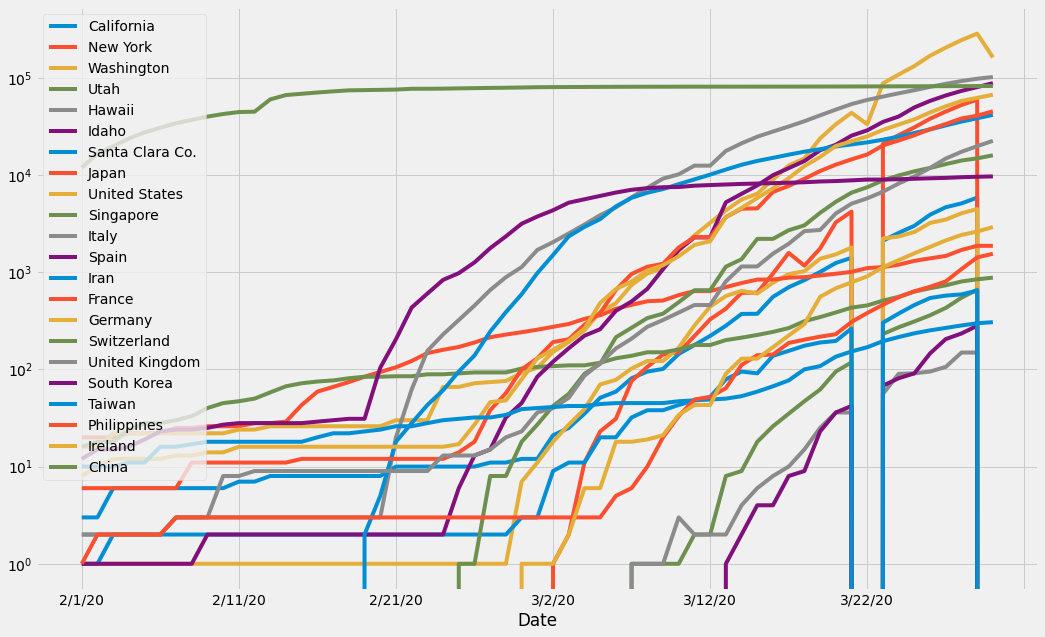

In [14]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)

# TEMP ONLY
Drop rows that have data glitches

In [15]:
df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

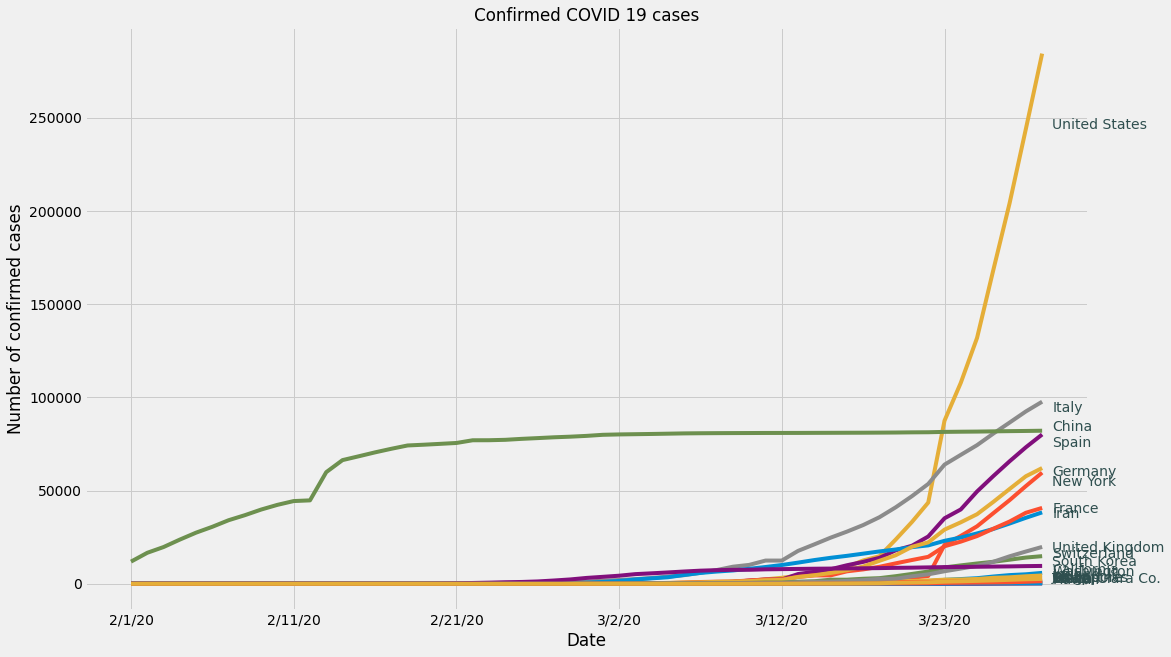

In [31]:
def label_lines(df, ax):
    for label in df.columns:
        previous = df.index[0]
        for xdays, datapoint in enumerate(df[label]):
            if pd.isnull(datapoint) or (xdays == len(df[label])-1):
                ax.annotate(label, (xdays, previous), 
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')
                break
            else:
                previous = datapoint

graph_data = df
#graph_data = newdf.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.show()

# Create a 'days since 100 cases' graph

In [17]:
df.head(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/1/20,3.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,16.0,16.0,...,0.0,6.0,8.0,0.0,2.0,12.0,10.0,1.0,0.0,11891.0
2/2/20,3.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,16.0,18.0,...,0.0,6.0,10.0,0.0,2.0,15.0,10.0,2.0,0.0,16630.0


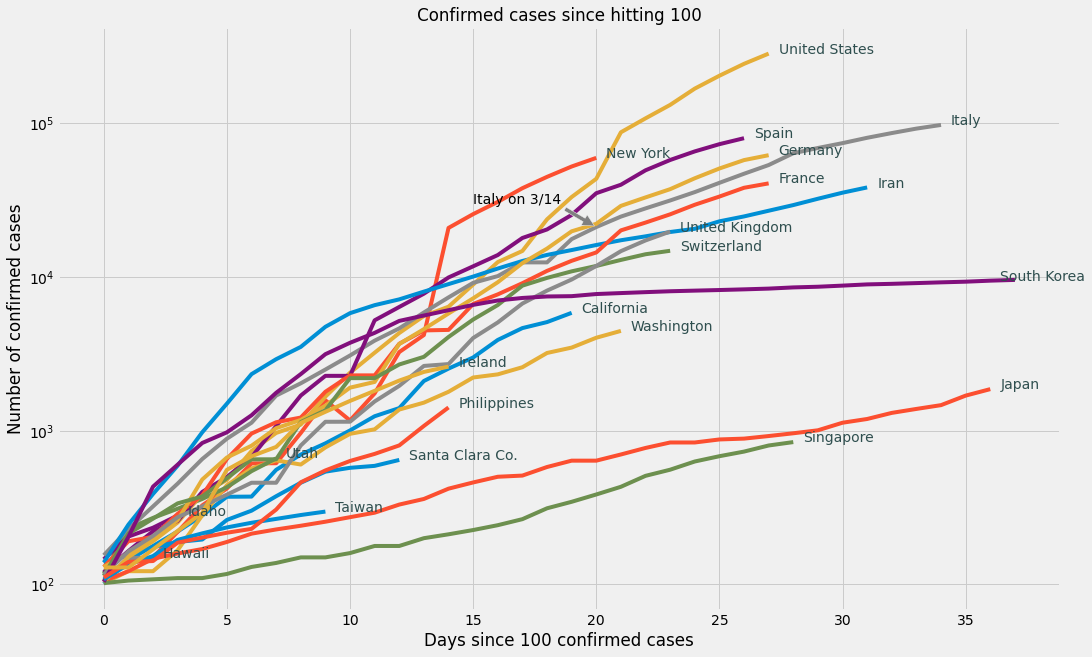

In [32]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
            arrowprops=dict(facecolor='grey', shrink=0.05),)


for location in daysSince100.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSince100[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSince100[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
            
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
        

# Cases relative to Population

In [34]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Santa Clara Co.': 2200000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/1/20,0.007548,0.000000,0.012825,0.000000,0.000000,0.000000,0.045455,0.015813,0.004834,0.273488,...,0.000000,0.009192,0.009548,0.000000,0.002946,0.023406,0.041987,0.000913,0.000000,0.826152
2/2/20,0.007548,0.000000,0.012825,0.000000,0.000000,0.000000,0.045455,0.015813,0.004834,0.307674,...,0.000000,0.009192,0.011935,0.000000,0.002946,0.029257,0.041987,0.001825,0.000000,1.155404
2/3/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.015813,0.006646,0.307674,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.029257,0.041987,0.001825,0.000000,1.369810
2/4/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.017395,0.006646,0.410232,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.031208,0.046186,0.001825,0.000000,1.647093
2/5/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.017395,0.006646,0.478604,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.037059,0.046186,0.001825,0.000000,1.906451
2/6/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.017395,0.006646,0.478604,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.044861,0.067180,0.001825,0.000000,2.125095
2/7/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.019767,0.006646,0.512791,...,0.000000,0.009192,0.015516,0.000000,0.004419,0.046812,0.067180,0.002738,0.000000,2.369863
2/8/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.019767,0.006646,0.564070,...,0.000000,0.016852,0.015516,0.000000,0.004419,0.046812,0.071378,0.002738,0.000000,2.557729
2/9/20,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.020557,0.006646,0.683721,...,0.000000,0.016852,0.016710,0.000000,0.004419,0.048762,0.075577,0.002738,0.000000,2.767202


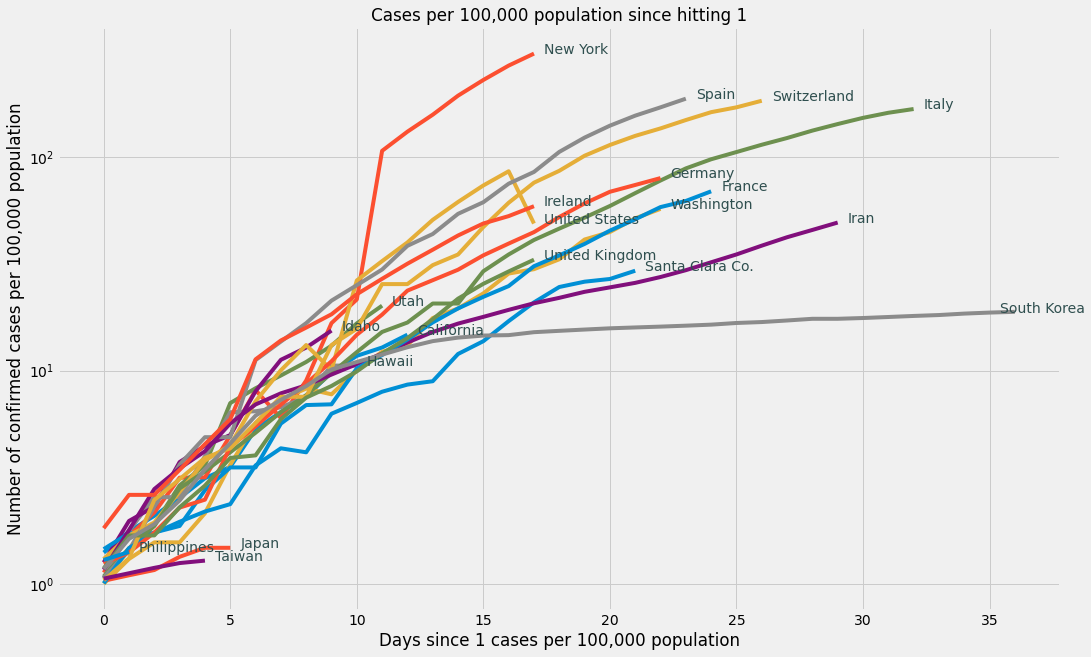

In [35]:
threshold = 1
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

for location in daysSincerate.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSincerate[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSincerate[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
plt.show()
        

In [21]:
daysSince100

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Spain,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland
0,101.0,106.0,102.0,118.0,106.0,146.0,138.0,105.0,104.0,102.0,...,120.0,139.0,130.0,130.0,114.0,116.0,104.0,108.0,111.0,129.0
1,144.0,142.0,122.0,231.0,149.0,205.0,155.0,122.0,151.0,106.0,...,165.0,245.0,191.0,159.0,214.0,164.0,204.0,135.0,140.0,129.0
2,178.0,150.0,122.0,271.0,149.0,234.0,175.0,147.0,191.0,108.0,...,222.0,388.0,204.0,196.0,268.0,207.0,433.0,153.0,142.0,169.0
3,221.0,220.0,167.0,311.0,NaN,281.0,189.0,159.0,253.0,110.0,...,259.0,593.0,288.0,262.0,337.0,274.0,602.0,195.0,187.0,223.0
4,281.0,327.0,282.0,360.0,NaN,NaN,196.0,170.0,389.0,110.0,...,400.0,978.0,380.0,482.0,374.0,322.0,833.0,215.0,202.0,292.0
5,372.0,421.0,442.0,429.0,NaN,NaN,263.0,189.0,479.0,117.0,...,500.0,1501.0,656.0,670.0,491.0,384.0,977.0,235.0,217.0,557.0
6,373.0,613.0,568.0,546.0,NaN,NaN,302.0,214.0,738.0,130.0,...,673.0,2336.0,959.0,799.0,652.0,459.0,1261.0,252.0,230.0,683.0
7,557.0,615.0,642.0,661.0,NaN,NaN,375.0,228.0,968.0,138.0,...,1073.0,2922.0,1136.0,1040.0,652.0,459.0,1766.0,267.0,307.0,785.0
8,700.0,967.0,603.0,NaN,NaN,NaN,459.0,241.0,1097.0,150.0,...,1695.0,3513.0,1219.0,1176.0,1139.0,802.0,2337.0,283.0,462.0,1125.0
9,828.0,1578.0,779.0,NaN,NaN,NaN,542.0,256.0,1667.0,150.0,...,2277.0,4747.0,1794.0,1457.0,1359.0,1144.0,3150.0,298.0,552.0,1329.0


# Look at growth factor changes

In [22]:
start_date = '2/27/20'
window = 3
location = ['California', 'Italy']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/27/20,11.0,0.0,1.0,0.0,0.0,0.0,2.0,214.0,74.0,93.0,...,245.0,38.0,46.0,8.0,15.0,1766.0,32.0,3.0,0.0,78600.0
2/28/20,11.0,0.0,1.0,0.0,0.0,0.0,2.0,228.0,76.0,93.0,...,388.0,57.0,48.0,8.0,20.0,2337.0,34.0,3.0,0.0,78928.0
2/29/20,12.0,0.0,7.0,0.0,0.0,0.0,3.0,241.0,92.0,102.0,...,593.0,100.0,79.0,18.0,23.0,3150.0,39.0,3.0,1.0,79356.0
3/1/20,12.0,0.0,11.0,0.0,0.0,0.0,3.0,256.0,104.0,106.0,...,978.0,130.0,130.0,27.0,36.0,3736.0,40.0,3.0,1.0,79932.0
3/2/20,21.0,1.0,18.0,0.0,0.0,0.0,9.0,274.0,151.0,108.0,...,1501.0,191.0,159.0,42.0,40.0,4335.0,41.0,3.0,1.0,80136.0
3/3/20,25.0,2.0,27.0,0.0,0.0,0.0,11.0,293.0,191.0,110.0,...,2336.0,204.0,196.0,56.0,51.0,5186.0,42.0,3.0,2.0,80261.0
3/4/20,35.0,11.0,39.0,0.0,0.0,0.0,11.0,331.0,253.0,110.0,...,2922.0,288.0,262.0,90.0,86.0,5621.0,42.0,3.0,6.0,80386.0
3/5/20,51.0,23.0,70.0,0.0,0.0,0.0,20.0,360.0,389.0,117.0,...,3513.0,380.0,482.0,114.0,116.0,6088.0,44.0,3.0,6.0,80537.0
3/6/20,59.0,31.0,78.0,0.0,0.0,0.0,20.0,420.0,479.0,130.0,...,4747.0,656.0,670.0,214.0,164.0,6593.0,45.0,5.0,18.0,80690.0


In [23]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,inf,NaN,inf,NaN,NaN,NaN,inf,0.928571,8.000000,inf,...,1.433566,2.263158,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878
3/1/20,0.000000,NaN,0.666667,NaN,NaN,NaN,0.000000,1.153846,0.750000,0.444444,...,1.878049,0.697674,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794
3/2/20,inf,inf,1.750000,NaN,NaN,NaN,inf,1.200000,3.916667,0.500000,...,1.358442,2.033333,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167
3/3/20,0.444444,1.000000,1.285714,NaN,NaN,NaN,0.333333,1.055556,0.851064,1.000000,...,1.596558,0.213115,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745
3/4/20,2.500000,9.000000,1.333333,NaN,NaN,NaN,0.000000,2.000000,1.550000,0.000000,...,0.701796,6.461538,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000
3/5/20,1.600000,1.333333,2.583333,NaN,NaN,NaN,inf,0.763158,2.193548,inf,...,1.008532,1.095238,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000
3/6/20,0.500000,0.666667,0.258065,NaN,NaN,NaN,0.000000,2.068966,0.661765,1.857143,...,2.087986,3.000000,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245


In [24]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
tempdf = df.drop('3/12/20', axis='index')
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Japan,United States,Singapore,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,inf,NaN,inf,NaN,NaN,NaN,inf,0.928571,8.000000,inf,...,1.433566,2.263158,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878
3/1/20,0.000000,NaN,0.666667,NaN,NaN,NaN,0.000000,1.153846,0.750000,0.444444,...,1.878049,0.697674,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794
3/2/20,inf,inf,1.750000,NaN,NaN,NaN,inf,1.200000,3.916667,0.500000,...,1.358442,2.033333,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167
3/3/20,0.444444,1.000000,1.285714,NaN,NaN,NaN,0.333333,1.055556,0.851064,1.000000,...,1.596558,0.213115,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745
3/4/20,2.500000,9.000000,1.333333,NaN,NaN,NaN,0.000000,2.000000,1.550000,0.000000,...,0.701796,6.461538,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000
3/5/20,1.600000,1.333333,2.583333,NaN,NaN,NaN,inf,0.763158,2.193548,inf,...,1.008532,1.095238,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000
3/6/20,0.500000,0.666667,0.258065,NaN,NaN,NaN,0.000000,2.068966,0.661765,1.857143,...,2.087986,3.000000,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245


Text(0.5, 1.0, 'Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n(3 day moving average)')

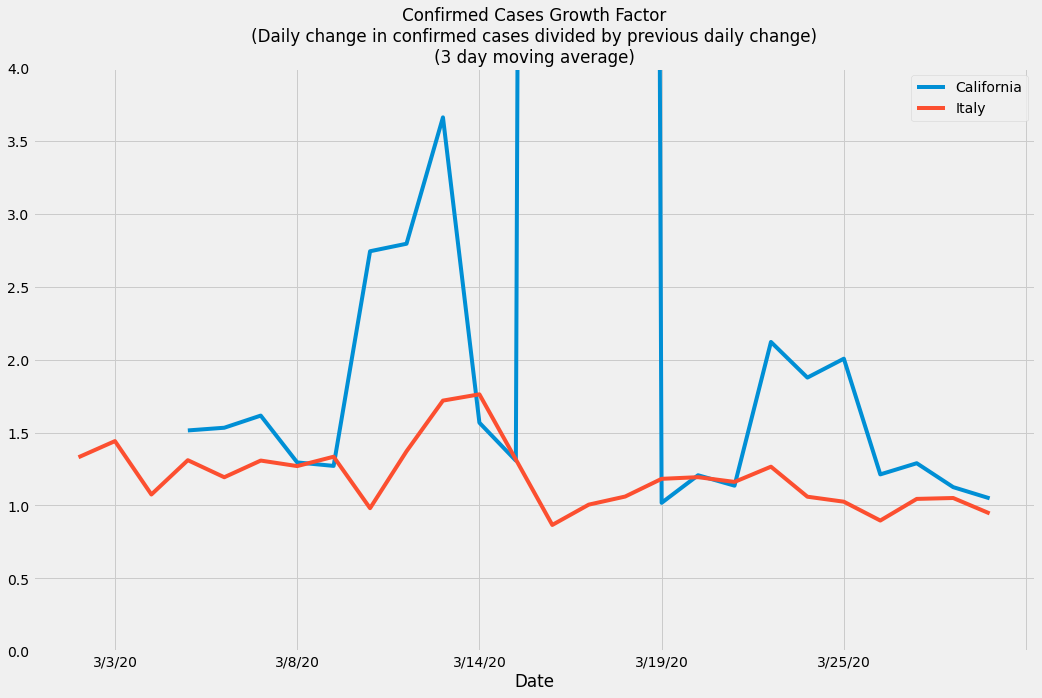

In [25]:
# graph the growth factors
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=4)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')